<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#Imports-and-Setups" data-toc-modified-id="Imports-and-Setups-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports and Setups</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Autoimport-my-code" data-toc-modified-id="Autoimport-my-code-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Autoimport my code</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li></ul></li><li><span><a href="#Reminders" data-toc-modified-id="Reminders-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reminders</a></span></li><li><span><a href="#Junctions" data-toc-modified-id="Junctions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Junctions</a></span><ul class="toc-item"><li><span><a href="#No---fracOverlap-1" data-toc-modified-id="No---fracOverlap-1-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>No --fracOverlap 1</a></span></li></ul></li><li><span><a href="#New-Airn" data-toc-modified-id="New-Airn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New Airn</a></span></li><li><span><a href="#Real-data-for-real" data-toc-modified-id="Real-data-for-real-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Real data for real</a></span><ul class="toc-item"><li><span><a href="#Spliced-unspliced-pairs" data-toc-modified-id="Spliced-unspliced-pairs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Spliced unspliced pairs</a></span></li><li><span><a href="#Back-to-abundance-data" data-toc-modified-id="Back-to-abundance-data-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Back to abundance data</a></span></li><li><span><a href="#Labeled-graphs" data-toc-modified-id="Labeled-graphs-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Labeled graphs</a></span></li></ul></li><li><span><a href="#extra-lncRNAs,-log,-and-communities" data-toc-modified-id="extra-lncRNAs,-log,-and-communities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>extra lncRNAs, log, and communities</a></span></li></ul></div>

# Watermark

In [1]:
%load_ext watermark
%watermark -a 'Jessime Kirk' -nmv --packages numpy,scipy,pandas,sklearn,matplotlib,seaborn,networkx,notebook,jupyter_contrib_nbextensions

Jessime Kirk Mon Nov 05 2018 

CPython 3.6.6
IPython 7.1.1

numpy 1.15.3
scipy 1.1.0
pandas 0.23.4
sklearn 0.20.0
matplotlib 3.0.1
seaborn 0.9.0
networkx 2.2
notebook 5.7.0
jupyter_contrib_nbextensions 0.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


# Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from tqdm import tqdm, trange, tqdm_notebook, tnrange

import champ

### Autoimport my code

In [2]:
pwd

'/home/jessime/Code/kmers3/Notebooks'

In [3]:
cd ..

/home/jessime/Code/kmers3


In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

### Plotting

In [6]:
%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Reminders

* All images should be saved as pdfs. They can be converted from pdf to png as necessary, but you can’t convert a png to pdf.
* When finished with a notebook, archive it with `jupyter nbconvert --to pdf nb.ipynb`

# Junctions

To get a sense of how bad we're overcounting the spliced isoform, we're going to look at junction spanning reads.

For megan's data, I ran:

```bash
featureCounts -O -J -a ../M14_full_unspliced.gtf -o megan_full_juctions_G.tab -T 16 -g transcript_id -s 2 -G /proj/seq/data/MM10_UCSC/Sequence/WholeGenomeFasta/genome.fa Aligned.out.sam
```

After some amount of investigation, I have little to no confidence that I understand that output.

The other file I have is `SJ.out.tab` from STAR. I'm going to poke around at that.

* column 1: chromosome
* column 2: first base of the intron (1-based)
* column 3: last base of the intron (1-based)
* column 4: strand (0: undefined, 1: +, 2: -)
* column 5: intron motif: 0: non-canonical; 1: GT/AG, 2: CT/AC, 3: GC/AG, 4: CT/GC, 5: AT/AC, 6: GT/AT
* column 6: 0: unannotated, 1: annotated (only if splice junctions database is used)
* column 7: number of uniquely mapping reads crossing the junction
* column 8: number of multi-mapping reads crossing the junction
* column 9: maximum spliced alignment overhang

In [14]:
infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_full_SJ.out.tab'
sj_df = pd.read_csv(infile, header=None, sep='\t')
columns = ['chr', 'start', 'end', 'strand', 'intron_motif', 'annotated', 
           'unique_count', 'm-m_count', 'max_overhang']
sj_df.columns = columns
print(sj_df.shape)
sj_df.head()

(252761, 9)


chr    start      end  strand  intron_motif  annotated  unique_count  \
0  chr1  3150775  3155945       2             2          0             0   
1  chr1  3207318  3213438       2             2          0             1   
2  chr1  3234249  3281292       2             2          0             1   
3  chr1  3472104  3472233       1             1          0             0   
4  chr1  3845188  3888944       1             1          0             0   

   m-m_count  max_overhang  
0          1            24  
1          0            23  
2          0            14  
3          6            38  
4          1            19

In [16]:
print(sj_df['strand'].value_counts())
print(sj_df['annotated'].value_counts())

1    126965
2    122945
0      2851
Name: strand, dtype: int64
1    130745
0    122016
Name: annotated, dtype: int64


This is the row for the single Airn-201 splice junction:

In [19]:
sj_df.iloc[215206]

chr                chr17
start           12741425
end             12814495
strand                 1
intron_motif           1
annotated              1
unique_count           2
m-m_count              0
max_overhang          33
Name: 215206, dtype: object

The probabability of a read overlapping the splice junction is ~:

In [22]:
read_len = 75
air_len = 1113
prob = read_len / air_len
prob

0.0673854447439353

Then the estimated total number of reads would be:

In [24]:
unique_reads = 2 
unique_reads/prob

29.680000000000003

Here's another way of estimating spliced abundance:

In [25]:
unspliced_len = 115237
unspliced_reads = 25601
unspliced_reads_per_base = unspliced_reads / unspliced_len
unspliced_reads_per_base

0.22215954945026337

In [26]:
air_reads = 317
air_reads_per_base = air_reads / air_len
air_reads_per_base

0.28481581311769993

In [28]:
spliced_minus_unspliced_rpb = air_reads_per_base - unspliced_reads_per_base
spliced_minus_unspliced_rpb

0.06265626366743657

In [31]:
real_spliced_reads = spliced_minus_unspliced_rpb * air_len
real_spliced_reads

69.7364214618569

So the new "Norm" would be:

In [30]:
air_norm = 2.741965
norm_factor = air_reads / air_norm
norm_factor

115.61052019263558

In [32]:
new_spliced_norm = real_spliced_reads / norm_factor
new_spliced_norm

0.6032013466046071

In [33]:
unspliced_norm = 4.909678
unspliced_norm / new_spliced_norm

8.13936843416606

Let's do the same logic for Xist, and a couple other proteins:

In [110]:
def spliced_to_unspliced_data(unspliced_len, 
                              unspliced_reads, 
                              spliced_len, 
                              spliced_reads, 
                              old_norm, 
                              unspliced_norm):
    unspliced_reads_per_base = unspliced_reads / unspliced_len
    spliced_reads_per_base = spliced_reads / spliced_len
    spliced_minus_unspliced_rpb = spliced_reads_per_base - unspliced_reads_per_base
    real_spliced_reads = spliced_minus_unspliced_rpb * spliced_len
    norm_factor = spliced_reads / old_norm
    new_spliced_norm = real_spliced_reads / norm_factor
    unspliced_spliced_ratio = unspliced_norm / new_spliced_norm
    decimals = 3
    print('Unspliced reads / base: ', round(unspliced_reads_per_base, decimals))
    print('Spliced reads / base: ', round(spliced_reads_per_base, decimals))
    print('Spliced - Unspliced: ', round(spliced_minus_unspliced_rpb, decimals))
    print('Real spliced reads: ', round(real_spliced_reads, decimals))
    print('New spliced norm: ', round(new_spliced_norm, decimals))
    print('Unspliced:Spliced ratio: ', round(unspliced_spliced_ratio, decimals))
    print('Spliced:Unspliced ratio: ', round(unspliced_spliced_ratio**-1, decimals))

For Xist:

In [61]:
spliced_to_unspliced_data(unspliced_len = 4927,
                          unspliced_reads = 967,
                          spliced_len = 17769,
                          spliced_reads = 123214,
                          old_norm = 66.756697,
                          unspliced_norm = 4.337424)

Unspliced reads / base:  0.196
Spliced reads / base:  6.934
Spliced - Unspliced:  6.738
Real spliced reads:  119726.559
New spliced norm:  64.867
Unspliced:Spliced ratio:  0.067
Spliced:Unspliced ratio:  14.955


In [45]:
infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_full_unspliced.tab'
unspliced_df = pd.read_csv(infile, index_col=0, sep='\t')
infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC_fc_transcripts_named.tab'
spliced_df = pd.read_csv(infile, index_col=0, sep='\t')

In [51]:
sample_unspliced = unspliced_df[unspliced_df['transcript_name'].isin(('Cdx2-un', 'Npm1-un', 'Myc-un'))]
sample_spliced = spliced_df[spliced_df['transcript_name'].isin(('Cdx2-201', 'Npm1-201', 'Myc-201'))]
display(sample_unspliced)
display(sample_spliced[['Length', 'Aligned.out.sam', 'Norm', 'transcript_name']])

transcript_id    Chr      Start        End Strand  Length  \
51900    UNSPLICED9446   chr5  147300805  147307270      -    4208   
104220  UNSPLICED19347  chr11   33152287   33163206      -    8268   
131744  UNSPLICED25286  chr15   61985391   61990374      +    2271   

        Aligned.out.sam       Norm transcript_name  
51900               460   2.415851         Cdx2-un  
104220            17773  47.505979         Npm1-un  
131744              492   4.787800          Myc-un

Length  Aligned.out.sam        Norm transcript_name
transcript_id                                                            
ENSMUST00000031650.3    2261             3135   13.348570        Cdx2-201
ENSMUST00000075641.9    1633           129065  760.886841        Npm1-201
ENSMUST00000022971.7    2338             7335   30.203230         Myc-201

In [62]:
for (ix1, unspliced_row), (ix2, spliced_row) in zip(sample_unspliced.iterrows(), sample_spliced.iterrows()):
    print(unspliced_row['transcript_name'], 'and', spliced_row['transcript_name'])
    spliced_to_unspliced_data(unspliced_len=unspliced_row['Length'],
                              unspliced_reads=unspliced_row['Aligned.out.sam'],
                              spliced_len=spliced_row['Length'],
                              spliced_reads=spliced_row['Aligned.out.sam'],
                              old_norm=spliced_row['Norm'],
                              unspliced_norm=unspliced_row['Norm'])
    print()

Cdx2-un and Cdx2-201
Unspliced reads / base:  0.109
Spliced reads / base:  1.387
Spliced - Unspliced:  1.277
Real spliced reads:  2887.837
New spliced norm:  12.296
Unspliced:Spliced ratio:  0.196
Spliced:Unspliced ratio:  5.09

Npm1-un and Npm1-201
Unspliced reads / base:  2.15
Spliced reads / base:  79.036
Spliced - Unspliced:  76.886
Real spliced reads:  125554.682
New spliced norm:  740.192
Unspliced:Spliced ratio:  0.064
Spliced:Unspliced ratio:  15.581

Myc-un and Myc-201
Unspliced reads / base:  0.217
Spliced reads / base:  3.137
Spliced - Unspliced:  2.921
Real spliced reads:  6828.485
New spliced norm:  28.118
Unspliced:Spliced ratio:  0.17
Spliced:Unspliced ratio:  5.873



## No --fracOverlap 1

Given this correction, does it make sense to not do the `--fracOverlap 1` parameter for the spliced counts? I'm going to run it, and just see what the numbers look like. My expectation is that it should add a few reads to spliced version. And one thing we really want to avoid is accusations that we're either overcounting unspliced transcripts or undercounting spliced isoforms.

In [66]:
%aimport feature_counts

In [67]:
!head -n 1 /home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC.tab
!cat /home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC.tab.summary

# Program:featureCounts v1.5.2; Command:"featureCounts" "-O" "-a" "../M14_lnc_pc_un_sp201_sorted.gtf" "-o" "megan_TSC.tab" "-g" "transcript_id" "-T" "16" "-s" "2" "Aligned.out.sam" 
Status	Aligned.out.sam
Assigned	122577654
Unassigned_Ambiguity	0
Unassigned_MultiMapping	42736046
Unassigned_NoFeatures	9216602
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_FragmentLength	0
Unassigned_Chimera	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_Duplicate	0


In [68]:
common = '/home/jessime/Research/mrna_lncrna/M14_sorted_gtf_ids_names.tab'
common = pd.read_csv(common, index_col=0, sep='\t')

infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC.tab'
fc = feature_counts.FeatureCounts(infile)
#Unique from /home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC_frac1.tab.summary
fc.normalize(unique_read_count=103872893)
fc.df.rename(columns={'Geneid': 'transcript_id'}, inplace=True)
fc.df.set_index('transcript_id', inplace=True)

df = fc.df.merge(common, left_index=True, right_index=True, validate='one_to_one')
print(fc.df.shape)
print(df.shape)
df.head()

(60829, 7)
(60829, 8)


Chr                    Start  \
transcript_id                                                   
ENSMUST00000193812.1            chr1                  3073253   
UNSPLICED0                      chr1                  3205901   
ENSMUST00000070533.4  chr1;chr1;chr1  3214482;3421702;3670552   
ENSMUST00000195335.1            chr1                  3365731   
ENSMUST00000192336.1            chr1                  3375556   

                                          End Strand  Length  Aligned.out.sam  \
transcript_id                                                                   
ENSMUST00000193812.1                  3074322      +    1070                0   
UNSPLICED0                            3671498      -  465598             1252   
ENSMUST00000070533.4  3216968;3421901;3671498  -;-;-    3634               31   
ENSMUST00000195335.1                  3368549      -    2819               10   
ENSMUST00000192336.1                  3377788      -    2233                6   

                          Norm    transcript_name  
transcript_id                                      
ENSMUST00000193812.1  0.000000  4933401J01Rik-201  
UNSPLICED0            0.025888            Xkr4-un  
ENSMUST00000070533.4  0.082125           Xkr4-201  
ENSMUST00000195335.1  0.034151        Gm37180-201  
ENSMUST00000192336.1  0.025868        Gm37363-201

In [69]:
outfile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC_fc_frac0_named.tab'
df.to_csv(outfile, sep='\t')
df[df['transcript_name'].isin(('Xist-201', 'Airn-201'))][['Length', 'Aligned.out.sam', 'Norm', 'transcript_name']]

Length  Aligned.out.sam       Norm transcript_name
transcript_id                                                           
ENSMUST00000079529.6    1113              410   3.546390        Airn-201
ENSMUST00000127786.2   17769           140409  76.072858        Xist-201

That's a decent difference in the number of counts. Let's run everything again.

In [74]:
unspliced_names = ('Xist-un', 'Airn-un', 'Cdx2-un', 'Npm1-un', 'Myc-un')
spliced_names = ('Xist-201', 'Airn-201', 'Cdx2-201', 'Npm1-201', 'Myc-201')
sample_unspliced = unspliced_df[unspliced_df['transcript_name'].isin(unspliced_names)]
sample_spliced = df[df['transcript_name'].isin(spliced_names)]
display(sample_spliced[['Length', 'Aligned.out.sam', 'Norm', 'transcript_name']])

Length  Aligned.out.sam        Norm transcript_name
transcript_id                                                            
ENSMUST00000031650.3    2261             3737   15.911837        Cdx2-201
ENSMUST00000075641.9    1633           148514  875.546030        Npm1-201
ENSMUST00000022971.7    2338             8601   35.416221         Myc-201
ENSMUST00000079529.6    1113              410    3.546390        Airn-201
ENSMUST00000127786.2   17769           140409   76.072858        Xist-201

In [75]:
for (ix1, unspliced_row), (ix2, spliced_row) in zip(sample_unspliced.iterrows(), sample_spliced.iterrows()):
    print(unspliced_row['transcript_name'], 'and', spliced_row['transcript_name'])
    spliced_to_unspliced_data(unspliced_len=unspliced_row['Length'],
                              unspliced_reads=unspliced_row['Aligned.out.sam'],
                              spliced_len=spliced_row['Length'],
                              spliced_reads=spliced_row['Aligned.out.sam'],
                              old_norm=spliced_row['Norm'],
                              unspliced_norm=unspliced_row['Norm'])
    print()

Cdx2-un and Cdx2-201
Unspliced reads / base:  0.109
Spliced reads / base:  1.653
Spliced - Unspliced:  1.543
Real spliced reads:  3489.837
New spliced norm:  14.859
Unspliced:Spliced ratio:  0.163
Spliced:Unspliced ratio:  6.151

Npm1-un and Npm1-201
Unspliced reads / base:  2.15
Spliced reads / base:  90.945
Spliced - Unspliced:  88.796
Real spliced reads:  145003.682
New spliced norm:  854.851
Unspliced:Spliced ratio:  0.056
Spliced:Unspliced ratio:  17.995

Myc-un and Myc-201
Unspliced reads / base:  0.217
Spliced reads / base:  3.679
Spliced - Unspliced:  3.462
Real spliced reads:  8094.485
New spliced norm:  33.331
Unspliced:Spliced ratio:  0.144
Spliced:Unspliced ratio:  6.962

Airn-un and Airn-201
Unspliced reads / base:  0.222
Spliced reads / base:  0.368
Spliced - Unspliced:  0.146
Real spliced reads:  162.736
New spliced norm:  1.408
Unspliced:Spliced ratio:  3.488
Spliced:Unspliced ratio:  0.287

Xist-un and Xist-201
Unspliced reads / base:  0.196
Spliced reads / base:  7.90

Let's use this correction scheme and see what the distribution looks like for the entire dataset (or, all of the spliced transcripts, or something).

I should have done this in October, but let's save the transcript_ids from the unspliced and spliced fasta files.

In [78]:
! grep ">" /home/jessime/Research/mrna_lncrna/M14_lnc_unspliced.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/M14_lnc_unspliced_transcript_ids.txt
!head -n 5 /home/jessime/Research/mrna_lncrna/M14_lnc_unspliced_transcript_ids.txt

ENSMUST00000193812.1
ENSMUST00000195335.1
ENSMUST00000192336.1
ENSMUST00000194099.1
UNSPLICED1


In [80]:
! grep ">" /home/jessime/Research/mrna_lncrna/M14_pc_unspliced.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/M14_pc_unspliced_transcript_ids.txt

! grep ">" /home/jessime/Research/mrna_lncrna/M14_lnc_spliced201.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/M14_lnc_spliced201_transcript_ids.txt

! grep ">" /home/jessime/Research/mrna_lncrna/M14_pc_spliced201.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/M14_pc_spliced201_transcript_ids.txt

In [85]:
def get_ids(path):
    with open(path) as infile:
        return [line.strip() for line in infile]

infile = '/home/jessime/Research/mrna_lncrna/M14_lnc_unspliced_transcript_ids.txt'
lnc_un_ids = get_ids(infile)
infile = '/home/jessime/Research/mrna_lncrna/M14_pc_unspliced_transcript_ids.txt'
pc_un_ids = get_ids(infile)
un_ids = lnc_un_ids + pc_un_ids

infile = '/home/jessime/Research/mrna_lncrna/M14_lnc_spliced201_transcript_ids.txt'
lnc_sp_ids = get_ids(infile)
infile = '/home/jessime/Research/mrna_lncrna/M14_pc_spliced201_transcript_ids.txt'
pc_sp_ids = get_ids(infile)
sp_ids = lnc_sp_ids + pc_sp_ids

# New Airn

From Mauro:

> Jessime I would like to dope in the 76kb airn annotation from UCSC and see what happens with counts.

I'm going to go with the 74kb Airn-201 annotation. 

But, I'm worried about doing this in a way that's reproducible and not a huge headache. I think what I've decided to do is:

* Make copies of the specific files I need to look at the read counts.
* Replace the old Air-un with the new definition
* If the RPKM of unspliced goes up significantly:
  * Rename the copies to the names of the original files.
  * Store a copy of the Airn-201-unspliced sequence
  * Dope coordinates and sequence into old files as needed.
  
This situation isn't perfect, but it's the best I've come up with.

In [89]:
!head -n 1 /home/jessime/Research/mrna_lncrna/wgEncode/megan_full_frac1_unique_airn.tab \
| tr -d \"

# Program:featureCounts v1.5.2; Command:featureCounts -a ../M14_full_unspliced_airn.gtf -o megan_full_frac1_unique_airn.tab -g transcript_id -T 16 --fracOverlap 1 -s 2 Aligned.out.sam 


In [90]:
!cat /home/jessime/Research/mrna_lncrna/wgEncode/megan_full_frac1_unique_airn.tab.summary

Status	Aligned.out.sam
Assigned	45247424
Unassigned_Ambiguity	59960058
Unassigned_MultiMapping	42736046
Unassigned_NoFeatures	26586774
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_FragmentLength	0
Unassigned_Chimera	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_Duplicate	0


The cell below does:

* label transcripts
* get unspliced transcripts
* calculate new lengths for unspliced
* renormalize
* save

In [98]:
common = '/home/jessime/Research/M14_full_unspliced_ids_names.tab'
common = pd.read_csv(common, index_col=0, sep='\t')

infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_full_frac1_unique_airn.tab'
fc = feature_counts.FeatureCounts(infile)
#Unique from /home/jessime/Research/mrna_lncrna/wgEncode/megan_full_frac1_unique_airn.tab.summary
unique_read_count = 45247424
fc.normalize(unique_read_count=unique_read_count)
fc.df.rename(columns={'Geneid': 'transcript_id'}, inplace=True)
fc.df.set_index('transcript_id', inplace=True)

df = fc.df.merge(common, left_index=True, right_index=True, validate='one_to_one')
print(df.shape)

def get_ids(path):
    with open(path) as infile:
        return [line.strip() for line in infile]

infile = '/home/jessime/Research/mrna_lncrna/M14_lnc_unspliced_transcript_ids.txt'
lnc_un_ids = get_ids(infile)
infile = '/home/jessime/Research/mrna_lncrna/M14_pc_unspliced_transcript_ids.txt'
pc_un_ids = get_ids(infile)
un_ids = lnc_un_ids + pc_un_ids

df.reset_index(inplace=True)
unspliced_df = df[df['transcript_id'].isin(un_ids)].copy()
print(len(un_ids))
print(unspliced_df.shape)

new_lengths = []
for i, row in tqdm_notebook(unspliced_df.iterrows()):
    # note that i is from the original index
    offset = int(row['Start'])
    unspliced_array = np.ones(int(row['End']) - offset + 1)
    base_name = '-'.join(row['transcript_name'].split('-')[:-1])
    j = i + 1
    
    #For each spliced transcript
    while True:
        next_row = df.iloc[j]
        if next_row['transcript_name'].startswith(base_name):
            exon_starts = next_row['Start'].split(';')
            exon_ends = next_row['End'].split(';')
            
            #Mask all the exons
            for start, end in zip(exon_starts, exon_ends):
                start = int(start) - offset
                end = int(end) - offset
                unspliced_array[start: end] = 0
            j += 1
        else:
            break
    new_lengths.append(int(sum(unspliced_array)))
    
unspliced_df['old_length'] = unspliced_df['Length']
unspliced_df['Length'] = new_lengths
norm = 1E9/(unspliced_df['Length']*unique_read_count)
unspliced_df['Norm'] = unspliced_df['Aligned.out.sam']*norm
unspliced_df.drop(columns=['old_length'], inplace=True)

outfile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_full_unspliced_airn.tab'
unspliced_df.to_csv(outfile, sep='\t')
unspliced_df[unspliced_df['transcript_name'].isin(('Xist-un', 'Airn-un'))]

(160035, 8)
33535
(33535, 9)


transcript_id    Chr      Start        End Strand  Length  \
139073  UNSPLICED26779  chr17   12741373   12815557      +   72772   
154529  UNSPLICED30126   chrX  103460375  103483217      -    4927   

        Aligned.out.sam      Norm transcript_name  
139073            23438  7.118072         Airn-un  
154529              967  4.337606         Xist-un

In [100]:
spliced_to_unspliced_data(unspliced_len=unspliced_df.loc[139073]['Length'],
                          unspliced_reads=unspliced_df.loc[139073]['Aligned.out.sam'],
                          spliced_len=sample_spliced.loc['ENSMUST00000079529.6']['Length'],
                          spliced_reads=sample_spliced.loc['ENSMUST00000079529.6']['Aligned.out.sam'],
                          old_norm=sample_spliced.loc['ENSMUST00000079529.6']['Norm'],
                          unspliced_norm=unspliced_df.loc[139073]['Norm'])

Unspliced reads / base:  0.322
Spliced reads / base:  0.368
Spliced - Unspliced:  0.046
Real spliced reads:  51.531
New spliced norm:  0.446
Unspliced:Spliced ratio:  15.969
Spliced:Unspliced ratio:  0.063


16:1 instead of 3.5:1 (Airn-un:Airn-201)

So, this correction seems good. Lets run everything on the real data now.

# Real data for real

The section in October was a bit preemptive. Let's try again.

I'm not going to immediately generate all the community plots though, since I want to think a little more about what my community definitions are, if I want to do log2 transforms, add RSX, etc.

Instead, I'm going to download and analyze the whole cell data, so I can plot some distribution, and see where XKA fall. 

I downloaded the files listed at:

`/home/jessime/Research/mrna_lncrna/wgEncode/files_whole_cell.txt`

which were downloaded with:

`download_whole_cell.sh`

aligned with:

`submit_star_wgEncode_cell.sh`

and counted with:

`submit_fc_wgEncode_cell.sh`

In [13]:
%aimport feature_counts

In [14]:
folder = '/home/jessime/Research/mrna_lncrna/wgEncode/'
base_files = [
    '{}hepG2_cell_npa_FC_{}.tab{}',
    '{}hepG2_cell_pap_FC_{}.tab{}',
    '{}k562_cell_npa_FC_{}.tab{}',
    '{}k562_cell_pap_FC_{}.tab{}'
]

I need to save csv files for the unspliced and spliced transcripts (labeled). Start with making the label files like I did for mouse.

In [11]:
! grep ">" /home/jessime/Research/mrna_lncrna/v26_lnc_unspliced.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/v26_lnc_unspliced_transcript_ids.txt

! grep ">" /home/jessime/Research/mrna_lncrna/v26_pc_unspliced.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/v26_pc_unspliced_transcript_ids.txt

! grep ">" /home/jessime/Research/mrna_lncrna/v26_lnc_spliced001.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/v26_lnc_spliced001_transcript_ids.txt

! grep ">" /home/jessime/Research/mrna_lncrna/v26_pc_spliced001.fa \
| awk '{print $1}' | cut -c2- > \
/home/jessime/Research/mrna_lncrna/v26_pc_spliced001_transcript_ids.txt

In [10]:
def get_ids(path):
    with open(path) as infile:
        return [line.strip() for line in infile]

In [124]:
def normalize_and_label(infile):
    print(infile)
    fc = feature_counts.FeatureCounts(infile)
    unique_read_count = fc.get_assigned_reads()
    fc.normalize(unique_read_count=unique_read_count)
    fc.df.rename(columns={'Geneid': 'transcript_id'}, inplace=True)
    fc.df.set_index('transcript_id', inplace=True)

    df = fc.df.merge(common, left_index=True, right_index=True, validate='one_to_one')
    assert fc.df.shape[0] == df.shape[0]
    return df, unique_read_count

def normalize_and_label_unique(bf):
    infile = bf.format(folder, 'unique', '')
    df, unique_read_count = normalize_and_label(infile)
    return df, unique_read_count

def normalize_and_label_multi(bf):
    infile = bf.format(folder, 'multi', '')
    df, unique_read_count = normalize_and_label(infile)
    return df

def grab_unspliced(df):
    df.reset_index(inplace=True) #need numbers for the index
    infile = '/home/jessime/Research/mrna_lncrna/v26_lnc_unspliced_transcript_ids.txt'
    lnc_un_ids = get_ids(infile)
    infile = '/home/jessime/Research/mrna_lncrna/v26_pc_unspliced_transcript_ids.txt'
    pc_un_ids = get_ids(infile)
    un_ids = lnc_un_ids + pc_un_ids
    df = df.drop(columns=['gene_id', 'spliced'])
    df = df.rename(columns={'common': 'transcript_name'})
    unspliced_df = df[df['transcript_id'].isin(un_ids)].copy()
    return df, unspliced_df

def grab_spliced(df):
    df.reset_index(inplace=True) #need numbers for the index
    infile = '/home/jessime/Research/mrna_lncrna/v26_lnc_spliced001_transcript_ids.txt'
    lnc_sp_ids = get_ids(infile)
    infile = '/home/jessime/Research/mrna_lncrna/v26_pc_spliced001_transcript_ids.txt'
    pc_sp_ids = get_ids(infile)
    sp_ids = lnc_sp_ids + pc_sp_ids
    df = df.drop(columns=['gene_id', 'spliced'])
    df = df.rename(columns={'common': 'transcript_name'})
    spliced_df = df[df['transcript_id'].isin(sp_ids)].copy()
    return spliced_df

def calc_new_lengths(unspliced_df, unique_df):
    new_lengths = []
    for i, row in tqdm_notebook(unspliced_df.iterrows()):
        # note that i is from the original index
        offset = int(row['Start'])
        unspliced_array = np.ones(int(row['End']) - offset + 1)
        base_name = '-'.join(row['transcript_name'].split('-')[:-1])
        j = i + 1

        #For each spliced transcript
        while True:
            next_row = unique_df.iloc[j]
            if next_row['transcript_name'][:-4] == base_name:
                exon_starts = next_row['Start'].split(';')
                exon_ends = next_row['End'].split(';')

                #Mask all the exons
                for start, end in zip(exon_starts, exon_ends):
                    start = int(start) - offset
                    end = int(end) - offset
                    unspliced_array[start: end] = 0
                j += 1
            else:
                break
        new_len = int(sum(unspliced_array))
        if new_len == 0:
            name = row['transcript_name']
            print(f'{name}: is 0 length')
        new_lengths.append(new_len)
    return new_lengths

def correct_len_and_norm(new_lengths, unspliced_df, unique_read_count):
    unspliced_df['old_length'] = unspliced_df['Length']
    unspliced_df['Length'] = new_lengths
    norm = 1E9/(unspliced_df['Length']*unique_read_count)
    unspliced_df['Norm'] = unspliced_df['Aligned.out.sam']*norm
    unspliced_df.drop(columns=['old_length'], inplace=True)
    return unspliced_df

In [125]:
common = '/home/jessime/Research/v26_full_unspliced_id2name.csv'
common = pd.read_csv(common, index_col=0)
common.set_index('transcript_id', inplace=True)

for bf in base_files:
    unique_df, unique_read_count = normalize_and_label_unique(bf)
    unique_df, unspliced_df = grab_unspliced(unique_df)
    new_lengths = calc_new_lengths(unspliced_df, unique_df)
    unspliced_df = correct_len_and_norm(new_lengths, unspliced_df, unique_read_count)
    outfile = bf.format(folder, 'unspliced', '')
    unspliced_df.to_csv(outfile)

/home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_npa_FC_unique.tab


RNU11-001: is 0 length
/home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_pap_FC_unique.tab


RNU11-001: is 0 length
/home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_npa_FC_unique.tab


RNU11-001: is 0 length
/home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_pap_FC_unique.tab


RNU11-001: is 0 length


I also need to get the spliced transcripts. That's pretty much the same, but requires different normalization (i.e. subtracting out the background of the unspliced.) 

To do this, I need a reliable map from a spliced transcript to its unspliced partner.

**Note:** It's worth pointing out that while all spliced transcripts have a partner, the reverse is not true. Some genes have only an unspliced version (e.g. KCNQ1OT1)

## Spliced unspliced pairs

In [43]:
%aimport gtf

In [51]:
v26_lnc_unspliced = '/home/jessime/Research/mrna_lncrna/v26_lnc_unspliced.gtf'
v26_lnc_unspliced = gtf.Maker(v26_lnc_unspliced)
v26_lnc_unspliced.append_attribute(col=0)
v26_lnc_unspliced.append_attribute(col=1)
v26_lnc_unspliced = v26_lnc_unspliced.expandedDF[['gene_id', 'transcript_id']]
print(v26_lnc_unspliced.shape)
v26_lnc_unspliced.head()

(15599, 2)


gene_id transcript_id
1   ENSG00000243485.5    UNSPLICED2
4   ENSG00000237613.2    UNSPLICED3
7   ENSG00000238009.6    UNSPLICED4
10  ENSG00000239945.1    UNSPLICED5
13  ENSG00000239906.1    UNSPLICED6

In [64]:
v26_pc_unspliced = '/home/jessime/Research/mrna_lncrna/v26_pc_unspliced.gtf'
v26_pc_unspliced = gtf.Maker(v26_pc_unspliced)
v26_pc_unspliced.append_attribute(col=0)
v26_pc_unspliced.append_attribute(col=1)
v26_pc_unspliced = v26_pc_unspliced.expandedDF[['gene_id', 'transcript_id']]

v26_unspliced = pd.concat([v26_lnc_unspliced, v26_pc_unspliced])
v26_unspliced.columns = ['gene_id', 'unspliced_transcript']
print(v26_unspliced.shape)
v26_unspliced.head()

(35416, 2)


gene_id unspliced_transcript
1   ENSG00000243485.5           UNSPLICED2
4   ENSG00000237613.2           UNSPLICED3
7   ENSG00000238009.6           UNSPLICED4
10  ENSG00000239945.1           UNSPLICED5
13  ENSG00000239906.1           UNSPLICED6

In [65]:
v26_lnc_spliced = '/home/jessime/Research/mrna_lncrna/v26_lnc_spliced001.gtf'
v26_lnc_spliced = gtf.Maker(v26_lnc_spliced)
v26_lnc_spliced.append_attribute(col=0)
v26_lnc_spliced.append_attribute(col=1)
v26_lnc_spliced = v26_lnc_spliced.expandedDF[['gene_id', 'transcript_id']]
v26_lnc_spliced.shape

(12065, 2)

In [67]:
v26_pc_spliced = '/home/jessime/Research/mrna_lncrna/v26_pc_spliced001.gtf'
v26_pc_spliced = gtf.Maker(v26_pc_spliced)
v26_pc_spliced.append_attribute(col=0)
v26_pc_spliced.append_attribute(col=1)
v26_pc_spliced = v26_pc_spliced.expandedDF[['gene_id', 'transcript_id']]

v26_spliced = pd.concat([v26_lnc_spliced, v26_pc_spliced])
v26_spliced.columns = ['gene_id', 'spliced_transcript']
print(v26_spliced.shape)
v26_spliced.head()

(30263, 2)


gene_id spliced_transcript
1   ENSG00000243485.5  ENST00000473358.1
6   ENSG00000237613.2  ENST00000417324.1
11  ENSG00000238009.6  ENST00000466430.5
17  ENSG00000239945.1  ENST00000495576.1
21  ENSG00000239906.1  ENST00000493797.1

In [69]:
v26_spliced_paired = pd.merge(v26_spliced, v26_unspliced, how='left', on='gene_id', validate='1:1')
print(v26_spliced_paired.shape)
v26_spliced_paired.head()

(30263, 3)


gene_id spliced_transcript unspliced_transcript
0  ENSG00000243485.5  ENST00000473358.1           UNSPLICED2
1  ENSG00000237613.2  ENST00000417324.1           UNSPLICED3
2  ENSG00000238009.6  ENST00000466430.5           UNSPLICED4
3  ENSG00000239945.1  ENST00000495576.1           UNSPLICED5
4  ENSG00000239906.1  ENST00000493797.1           UNSPLICED6

In [70]:
outfile = '/home/jessime/Research/mrna_lncrna/v26_spliced_unspliced_pairs.csv'
v26_spliced_paired.to_csv(outfile)

Might as well go ahead and repeat for mouse as well.

In [71]:
M14_lnc_unspliced = '/home/jessime/Research/mrna_lncrna/M14_lnc_unspliced.gtf'
M14_lnc_unspliced = gtf.Maker(M14_lnc_unspliced)
M14_lnc_unspliced.append_attribute(col=0)
M14_lnc_unspliced.append_attribute(col=1)
M14_lnc_unspliced = M14_lnc_unspliced.expandedDF[['gene_id', 'transcript_id']]

M14_pc_unspliced = '/home/jessime/Research/mrna_lncrna/M14_pc_unspliced.gtf'
M14_pc_unspliced = gtf.Maker(M14_pc_unspliced)
M14_pc_unspliced.append_attribute(col=0)
M14_pc_unspliced.append_attribute(col=1)
M14_pc_unspliced = M14_pc_unspliced.expandedDF[['gene_id', 'transcript_id']]
M14_unspliced = pd.concat([M14_lnc_unspliced, M14_pc_unspliced])
M14_unspliced.columns = ['gene_id', 'unspliced_transcript']

M14_lnc_spliced = '/home/jessime/Research/mrna_lncrna/M14_lnc_spliced201.gtf'
M14_lnc_spliced = gtf.Maker(M14_lnc_spliced)
M14_lnc_spliced.append_attribute(col=0)
M14_lnc_spliced.append_attribute(col=1)
M14_lnc_spliced = M14_lnc_spliced.expandedDF[['gene_id', 'transcript_id']]

M14_pc_spliced = '/home/jessime/Research/mrna_lncrna/M14_pc_spliced201.gtf'
M14_pc_spliced = gtf.Maker(M14_pc_spliced)
M14_pc_spliced.append_attribute(col=0)
M14_pc_spliced.append_attribute(col=1)
M14_pc_spliced = M14_pc_spliced.expandedDF[['gene_id', 'transcript_id']]
M14_spliced = pd.concat([M14_lnc_spliced, M14_pc_spliced])
M14_spliced.columns = ['gene_id', 'spliced_transcript']

M14_spliced_paired = pd.merge(M14_spliced, M14_unspliced, how='left', on='gene_id', validate='1:1')
outfile = '/home/jessime/Research/mrna_lncrna/M14_spliced_unspliced_pairs.csv'
M14_spliced_paired.to_csv(outfile)
print(M14_spliced_paired.shape)
M14_spliced_paired.head()

(27294, 3)


gene_id    spliced_transcript unspliced_transcript
0  ENSMUSG00000089699.1  ENSMUST00000161581.1           UNSPLICED1
1  ENSMUSG00000102331.1  ENSMUST00000192692.1           UNSPLICED2
2  ENSMUSG00000102343.1  ENSMUST00000192427.1           UNSPLICED3
3  ENSMUSG00000104328.1  ENSMUST00000195771.1           UNSPLICED9
4  ENSMUSG00000085623.1  ENSMUST00000144339.1          UNSPLICED15

## Back to abundance data

Hmm... all my functions are really far away now. That's fine, I suppose. I'll move just the ones I'm working on now down here.

In [107]:
def subtract_background_reads(unspliced_len, 
                              unspliced_reads, 
                              spliced_len, 
                              spliced_reads, 
                              old_norm, 
                              unspliced_norm):
    unspliced_reads_per_base = unspliced_reads / unspliced_len
    spliced_reads_per_base = spliced_reads / spliced_len
    spliced_minus_unspliced_rpb = spliced_reads_per_base - unspliced_reads_per_base
    real_spliced_reads = spliced_minus_unspliced_rpb * spliced_len
    norm_factor = spliced_reads / old_norm
    new_spliced_norm = real_spliced_reads / norm_factor
    return real_spliced_reads, new_spliced_norm

def setup_unspliced_pairs(bf):
    unspliced_df = pd.read_csv(bf.format(folder, 'unspliced', ''), index_col=0)
    unspliced_df.set_index('transcript_id', inplace=True)
    infile = '/home/jessime/Research/mrna_lncrna/v26_spliced_unspliced_pairs.csv'
    v26_spliced_paired = pd.read_csv(infile, index_col=0)
    v26_spliced_paired = dict(zip(v26_spliced_paired['spliced_transcript'],
                              v26_spliced_paired['unspliced_transcript']))
    return v26_spliced_paired, unspliced_df

def correct_spliced_norm(spliced_df, bf):
    # Slow?
    v26_spliced_paired, unspliced_df = setup_unspliced_pairs(bf) 
    spliced_reads_ls = []
    spliced_norms_ls = []
    for ix, spliced_row in spliced_df.iterrows():
        correct_unspliced = v26_spliced_paired[spliced_row['transcript_id']]
        unspliced_row = unspliced_df.loc[correct_unspliced]
        spliced_reads=spliced_row['Aligned.out.sam']
        if spliced_reads == 0:
            spliced_reads_ls.append(0)
            spliced_norms_ls.append(0)
            continue
        new_spliced_reads, new_spliced_norm = subtract_background_reads(
            unspliced_len=unspliced_row['Length'],
            unspliced_reads=unspliced_row['Aligned.out.sam'],
            spliced_len=spliced_row['Length'],
            spliced_reads=spliced_reads,
            old_norm=spliced_row['Norm'],
            unspliced_norm=unspliced_row['Norm'])
        spliced_reads_ls.append(new_spliced_reads)
        spliced_norms_ls.append(new_spliced_norm)
    spliced_df['Aligned.out.sam'] = spliced_reads_ls
    spliced_df['Norm'] = spliced_norms_ls
    return spliced_df

In [126]:
for bf in base_files:
    multi_df = normalize_and_label_multi(bf)
    spliced_df = grab_spliced(multi_df)
    display(spliced_df.head())
    spliced_df = correct_spliced_norm(spliced_df, bf)
    print(spliced_df.shape)
    display(spliced_df.head())
    break

/home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_npa_FC_multi.tab


transcript_id                  Chr                      Start  \
1   ENST00000473358.1       chr1;chr1;chr1          29554;30564;30976   
3   ENST00000417324.1       chr1;chr1;chr1          34554;35277;35721   
6   ENST00000466430.5  chr1;chr1;chr1;chr1  89295;92091;112700;120775   
8   ENST00000495576.1            chr1;chr1                89551;90287   
10  ENST00000493797.1            chr1;chr1              139790;140075   

                          End   Strand  Length  Aligned.out.sam      Norm  \
1           30039;30667;31097    +;+;+     712                1  0.009896   
3           35174;35481;36081    -;-;-    1187                0  0.000000   
6   91629;92240;112804;120932  -;-;-;-    2748                3  0.007692   
8                 90050;91105      -;-    1319                3  0.016026   
10              139847;140339      -;-     323                0  0.000000   

      transcript_name  
1     MIR1302-2HG-001  
3         FAM138A-001  
6    RP11-34P13.7-001  
8    RP11-34P13.8-001  
10  RP11-34P13.14-001

(30263, 9)


transcript_id                  Chr                      Start  \
1   ENST00000473358.1       chr1;chr1;chr1          29554;30564;30976   
3   ENST00000417324.1       chr1;chr1;chr1          34554;35277;35721   
6   ENST00000466430.5  chr1;chr1;chr1;chr1  89295;92091;112700;120775   
8   ENST00000495576.1            chr1;chr1                89551;90287   
10  ENST00000493797.1            chr1;chr1              139790;140075   

                          End   Strand  Length  Aligned.out.sam      Norm  \
1           30039;30667;31097    +;+;+     712         1.000000  0.009896   
3           35174;35481;36081    -;-;-    1187         0.000000  0.000000   
6   91629;92240;112804;120932  -;-;-;-    2748        -0.577598 -0.001481   
8                 90050;91105      -;-    1319         3.000000  0.016026   
10              139847;140339      -;-     323         0.000000  0.000000   

      transcript_name  
1     MIR1302-2HG-001  
3         FAM138A-001  
6    RP11-34P13.7-001  
8    RP11-34P13.8-001  
10  RP11-34P13.14-001

I need to confirm that these numbers are right. I've done that outside of the notebook, to save on clutter. But everything looks good at this point. Right now, I've got negative values, which isn't going to work, but we knew that was going to happen. So, I really have two goals here. I need to confirm that the code I have now gives me number I would expect, and I need to come up with a scheme to correct for negative numbers (which is basically going to amount to setting to 0). Let's see how many value are negative.

In [127]:
(spliced_df['Norm'] < 0).sum()

1948

Not that many. Let's look at the full distribution.

In [128]:
spliced_df['Norm'].sort_values()

50707    -796.634627
56178    -271.625068
39259     -86.150164
50311     -79.321448
3526      -71.368098
55385     -62.604389
49971     -47.193990
10468     -42.226906
60344     -36.896876
39707     -30.627020
53595     -27.064697
10054     -25.653488
53980     -25.445106
46177     -25.365490
53567     -24.726087
33465     -22.060388
49071     -20.175903
53575     -19.153222
20767     -18.360502
42522     -17.887198
46347     -16.387759
54548     -14.436986
3176      -13.819100
43501     -12.984020
4154      -12.905415
59358     -12.823001
30394     -12.808358
63732     -12.717093
7113      -12.617113
1995      -11.997531
            ...     
12960     465.731102
48002     488.460606
58221     507.424610
37591     509.239658
62917     516.483640
59139     529.955683
50371     542.308428
20956     547.203216
35094     558.297146
36880     577.181261
60732     585.376354
30641     625.107050
57486     649.358342
23204     665.251350
6551      682.245699
4230      690.854942
51986     697

In [141]:
sns.distplot(np.log(spliced_df['Norm'].clip_lower(1)))
plt.title('All Spliced HepG2 NPA Whole-Cell')
plt.xlabel('Log(Norm)')
plt.ylabel('Density')
plt.show()

In [149]:
expressed_spliced = spliced_df[spliced_df['Norm'] >.1]
sns.distplot(np.log(expressed_spliced['Norm']))
plt.show()

Okay, let's run them all, save the files, and make the plots.

In [154]:
for bf in base_files:
    multi_df = normalize_and_label_multi(bf)
    spliced_df = grab_spliced(multi_df)
    spliced_df = correct_spliced_norm(spliced_df, bf)
    outfile = bf.format(folder, 'spliced', '')
    spliced_df.to_csv(outfile)
    print('-> ', outfile, '\n')

/home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_npa_FC_multi.tab
->  /home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_npa_FC_spliced.tab 

/home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_pap_FC_multi.tab
->  /home/jessime/Research/mrna_lncrna/wgEncode/hepG2_cell_pap_FC_spliced.tab 

/home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_npa_FC_multi.tab
->  /home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_npa_FC_spliced.tab 

/home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_pap_FC_multi.tab
->  /home/jessime/Research/mrna_lncrna/wgEncode/k562_cell_pap_FC_spliced.tab 



We only care about plots for the `npa` data sets.

In [182]:
splice_status = ['unspliced', 'unspliced', 'spliced', 'spliced']
index_ls = [0, 2, 0, 2]
cell_type = ['HepG2', 'K562', 'HepG2', 'K562']

for ss, il, ct in zip(splice_status, index_ls, cell_type):
    infile = base_files[il].format(folder, ss, '')
    exp_data = pd.read_csv(infile, index_col=0)
    expressed = exp_data[exp_data['Norm'] > .1]
    sns.distplot(np.log(expressed['Norm']),
                 label='{} {}: n={}'.format(ct, ss.capitalize(), len(expressed)))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(f'Log(Norm)')
plt.ylabel('Density')
#outfile = '/home/jessime/Research/pics/hepG2_k562_spliced_unspliced.pdf'
#plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

Before I go any farther, I want to convince myself that my normalization is okay for comparing across unsplice/spliced data sets like this.

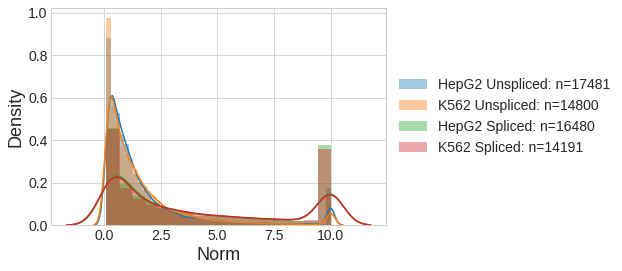

In [183]:
for ss, il, ct in zip(splice_status, index_ls, cell_type):
    infile = base_files[il].format(folder, ss, '')
    exp_data = pd.read_csv(infile, index_col=0)
    expressed = exp_data[exp_data['Norm'] > .1]
    sns.distplot(expressed['Norm'].clip_upper(10),
                 label='{} {}: n={}'.format(
                     ct, ss.capitalize(), len(expressed)))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Norm')
plt.ylabel('Density')
plt.show()

Gross. Definitely want to be using log.

Let's start digging up labels.

In [188]:
for ss, il, ct in zip(splice_status, index_ls, cell_type):
    infile = base_files[il].format(folder, ss, '')
    exp_data = pd.read_csv(infile, index_col=0)
    print(ct)
    if ss == 'unspliced':
        display(exp_data[exp_data['transcript_name'].isin(('KCNQ1OT1-001',))])
    else:
        display(exp_data[exp_data['transcript_name'].isin(('XIST-001',))][
            ['transcript_id','Chr','Length','Aligned.out.sam','Norm','transcript_name']
        ])

HepG2


transcript_id    Chr    Start      End Strand  Length  \
119032  ENST00000597346.1  chr11  2608328  2699994      -   91667   

        Aligned.out.sam       Norm transcript_name  
119032            70308  12.926415    KCNQ1OT1-001

K562


transcript_id    Chr    Start      End Strand  Length  \
119032  ENST00000597346.1  chr11  2608328  2699994      -   91667   

        Aligned.out.sam      Norm transcript_name  
119032            32928  5.145636    KCNQ1OT1-001

HepG2


transcript_id                            Chr  Length  \
64372  ENST00000429829.5  chrX;chrX;chrX;chrX;chrX;chrX   19275   

       Aligned.out.sam      Norm transcript_name  
64372      1642.753086  0.600523        XIST-001

K562


transcript_id                            Chr  Length  \
64372  ENST00000429829.5  chrX;chrX;chrX;chrX;chrX;chrX   19275   

       Aligned.out.sam       Norm transcript_name  
64372     62404.759259  22.333964        XIST-001

Ugh, the other label I need to get is protein coding vs lncRNA. Mauro wants those separated out too. 

## Labeled graphs

In [219]:
plt.rcParams['figure.figsize'] = [9.0, 6.0]
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24

In [201]:
lnc_spliced_transcript_ids = '/home/jessime/Research/mrna_lncrna/v26_lnc_spliced001_transcript_ids.txt'
with open(lnc_spliced_transcript_ids) as lnc_spliced_transcript_ids:
    lnc_spliced_transcript_ids = set(line.strip() for line in lnc_spliced_transcript_ids)
    
lnc_unspliced_transcript_ids = '/home/jessime/Research/mrna_lncrna/v26_lnc_unspliced_transcript_ids.txt'
with open(lnc_unspliced_transcript_ids) as lnc_unspliced_transcript_ids:
    lnc_unspliced_transcript_ids = set(line.strip() for line in lnc_unspliced_transcript_ids)

/home/jessime/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


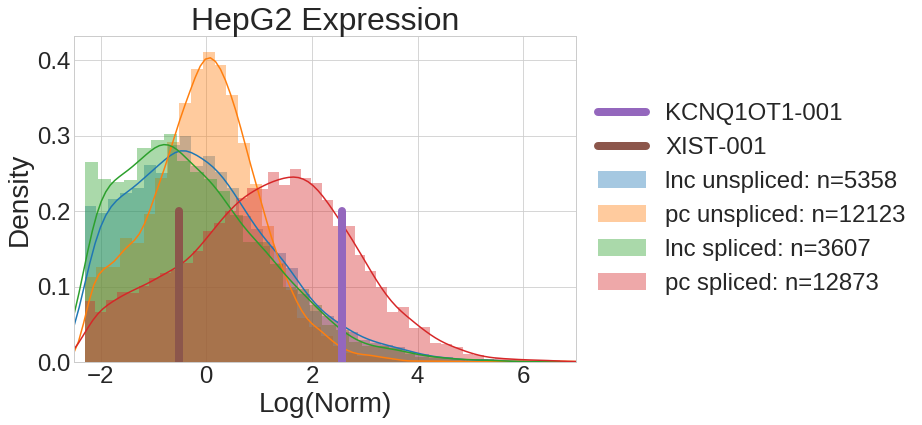

In [231]:
#HepG2

infile = folder + 'hepG2_cell_npa_FC_unspliced.tab'
unspliced = pd.read_csv(infile, index_col=0)
unspliced = unspliced[unspliced['Norm'] > .1]
lnc_unspliced = unspliced[unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(lnc_unspliced['Norm']),
             label='lnc unspliced: n={}'.format(len(lnc_unspliced)))
pc_unspliced = unspliced[~unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(pc_unspliced['Norm']),
             label='pc unspliced: n={}'.format(len(pc_unspliced)))

infile = folder + 'hepG2_cell_npa_FC_spliced.tab'
spliced = pd.read_csv(infile, index_col=0)
spliced = spliced[spliced['Norm'] > .1]
lnc_spliced = spliced[spliced['transcript_id'].isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(lnc_spliced['Norm']),
             label='lnc spliced: n={}'.format(len(lnc_spliced)))
pc_spliced = spliced[~spliced['transcript_id'].isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(pc_spliced['Norm']),
             label='pc spliced: n={}'.format(len(pc_spliced)))

kcnq1 = np.log(unspliced[unspliced['transcript_name'] == ('KCNQ1OT1-001')].iloc[0]['Norm'])
plt.plot((kcnq1, kcnq1), (0, .2), linewidth=8, label='KCNQ1OT1-001')
xist = np.log(spliced[spliced['transcript_name'] == ('XIST-001')].iloc[0]['Norm'])
plt.plot((xist, xist), (0, .2), linewidth=8, label='XIST-001')

plt.title('HepG2 Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(f'Log(Norm)')
plt.ylabel('Density')
plt.xlim((-2.5, 7))
outfile = '/home/jessime/Research/pics/hepG2_expression_labeled.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

This next plot should pretty much be the same, except that Xist is expressed here.

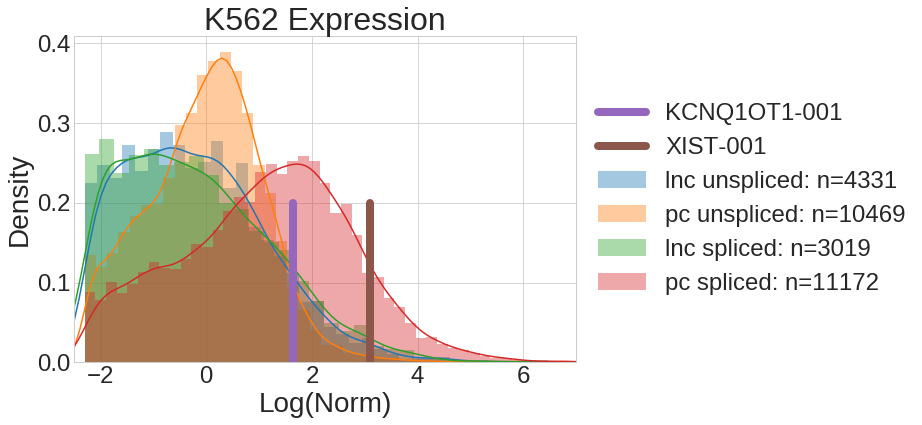

In [232]:
#K562

infile = folder + 'k562_cell_npa_FC_unspliced.tab'
unspliced = pd.read_csv(infile, index_col=0)
unspliced = unspliced[unspliced['Norm'] > .1]
lnc_unspliced = unspliced[unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(lnc_unspliced['Norm']),
             label='lnc unspliced: n={}'.format(len(lnc_unspliced)))
pc_unspliced = unspliced[~unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(pc_unspliced['Norm']),
             label='pc unspliced: n={}'.format(len(pc_unspliced)))

infile = folder + 'k562_cell_npa_FC_spliced.tab'
spliced = pd.read_csv(infile, index_col=0)
spliced = spliced[spliced['Norm'] > .1]
lnc_spliced = spliced[spliced['transcript_id'].isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(lnc_spliced['Norm']),
             label='lnc spliced: n={}'.format(len(lnc_spliced)))
pc_spliced = spliced[~spliced['transcript_id'].isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(pc_spliced['Norm']),
             label='pc spliced: n={}'.format(len(pc_spliced)))

kcnq1 = np.log(unspliced[unspliced['transcript_name'] == ('KCNQ1OT1-001')].iloc[0]['Norm'])
plt.plot((kcnq1, kcnq1), (0, .2), linewidth=8, label='KCNQ1OT1-001')
xist = np.log(spliced[spliced['transcript_name'] == ('XIST-001')].iloc[0]['Norm'])
plt.plot((xist, xist), (0, .2), linewidth=8, label='XIST-001')

plt.title('K562 Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(f'Log(Norm)')
plt.ylabel('Density')
plt.xlim((-2.5, 7))
outfile = '/home/jessime/Research/pics/k562_expression_labeled.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

Before I make the TSC graphs, I have to make a spliced-only file.

In [225]:
infile = '/home/jessime/Research/mrna_lncrna/M14_lnc_spliced201_transcript_ids.txt'
with open(infile) as spliced_ids:
    spliced_ids = set(line.strip() for line in spliced_ids)
print(len(spliced_ids))
infile = '/home/jessime/Research/mrna_lncrna/M14_pc_spliced201_transcript_ids.txt'
with open(infile) as spliced_ids2:
    spliced_ids |= set(line.strip() for line in spliced_ids2)
print(len(spliced_ids))

7950
27294


In [230]:
infile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_TSC_fc_transcripts_named.tab'
df = pd.read_csv(infile, index_col=0, sep='\t')
print(df.shape)
df = df[df.index.isin(spliced_ids)]
print(df.shape)
outfile = '/home/jessime/Research/mrna_lncrna/wgEncode/megan_full_spliced.tab'
df.to_csv(outfile)

(60829, 8)
(27294, 8)


In [233]:
lnc_spliced_transcript_ids = '/home/jessime/Research/mrna_lncrna/M14_lnc_spliced201_transcript_ids.txt'
with open(lnc_spliced_transcript_ids) as lnc_spliced_transcript_ids:
    lnc_spliced_transcript_ids = set(line.strip() for line in lnc_spliced_transcript_ids)
    
lnc_unspliced_transcript_ids = '/home/jessime/Research/mrna_lncrna/M14_lnc_unspliced_transcript_ids.txt'
with open(lnc_unspliced_transcript_ids) as lnc_unspliced_transcript_ids:
    lnc_unspliced_transcript_ids = set(line.strip() for line in lnc_unspliced_transcript_ids)

In [239]:
#TSC

infile = folder + 'megan_full_unspliced_airn.tab'
unspliced = pd.read_csv(infile, index_col=0, sep='\t')
unspliced = unspliced[unspliced['Norm'] > .1]
lnc_unspliced = unspliced[unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(lnc_unspliced['Norm']),
             label='lnc Unspliced: n={}'.format(len(lnc_unspliced)))
pc_unspliced = unspliced[~unspliced['transcript_id'].isin(lnc_unspliced_transcript_ids)]
sns.distplot(np.log(pc_unspliced['Norm']),
             label='pc Unspliced: n={}'.format(len(pc_unspliced)))

infile = folder + 'megan_full_spliced.tab'
spliced = pd.read_csv(infile, index_col=0)
spliced = spliced[spliced['Norm'] > .1]
lnc_spliced = spliced[spliced.index.isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(lnc_spliced['Norm']),
             label='lnc Spliced: n={}'.format(len(lnc_spliced)))
pc_spliced = spliced[~spliced.index.isin(lnc_spliced_transcript_ids)]
sns.distplot(np.log(pc_spliced['Norm']),
             label='pc Spliced: n={}'.format(len(pc_spliced)))

kcnq1 = np.log(unspliced[unspliced['transcript_name'] == ('Kcnq1ot1-201')].iloc[0]['Norm'])
plt.plot((kcnq1, kcnq1), (0, .2), linewidth=8, label='Kcnq1ot1-201')
airn = np.log(unspliced[unspliced['transcript_name'] == ('Airn-un')].iloc[0]['Norm'])
plt.plot((airn, airn), (0, .2), linewidth=8, label='Airn-un')
xist = np.log(spliced[spliced['transcript_name'] == ('Xist-201')].iloc[0]['Norm'])
plt.plot((xist, xist), (0, .2), linewidth=8, label='Xist-201')

plt.title('TSC')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(f'Log(Norm)')
plt.ylabel('Density')
plt.xlim((-2.5, 7))
outfile = '/home/jessime/Research/pics/TSC_expression_labeled.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

# extra lncRNAs, log, and communities

I'm going to visit communities again, and basically just do the same thing I did last time to create them. The upsides will be:

1. I can get a refresher on exactly how the communities were created.
2. The code for creating the communities will be cleaner.
3. I can added in RSX. Since I'm doing this, I'm going to try to be proactive and just add in all the transcripts that we doped into v22 (and mouse) last time.
4. I can create communities that have been log2 normalized, and see how those compare.

In [240]:
!tail -n 18 /home/jessime/Research/v22_transcripts01_extend.fa \
> /home/jessime/Research/indv_seqs/v22_extension.fa

In [241]:
!tail -n 28 /home/jessime/Research/M5_transcripts01_extend4.fa \
> /home/jessime/Research/indv_seqs/M5_extension4.fa

I've made a little space on my drive by doing:

```
gzip lastz_v26_combo.tab
```

which made `lastz_v26_combo.tab.gz`. And: 

```
7z a -r v22_align.zip v22_align/
```

which made `v22_align.zip`.

Because of both memory and HD space, I'm going to do this all on Longleaf. As usual, I'll copy what I do down here, starting with concat-ing the extensions.

```
cat v26_combo.fa v22_extension.fa > v26_extend.fa
cat M14_combo.fa M5_extension4.fa > M14_extend.fa
```

```bash
srun -n 16 --time=8:00:00 --mem=64g --pty ipython
```

then

```python
%load_ext autoreload
autoreload 2
%aimport kmer_counts
%aimport pearson
%aimport network

infasta = '/pine/scr/j/e/jessime/networks/v26_extend.fa'
outfile = '/pine/scr/j/e/jessime/networks/v26_extend_log.npy'
counter = kmer_counts.BasicCounter(infasta=infasta, outfile=outfile, log2=True)
counts = counter.make_count_file()
sim_sparse = pearson.chunk_sparse_pearson(counts, counts, limit=.1)
map_path='/pine/scr/j/e/jessime/networks/v26_extend_log_ntm.pkl'
el_path = '/pine/scr/j/e/jessime/networks/v26_extend_log_el.tab'
gm = network.GraphMaker2(sim_sparse, el_path=el_path, map_path=map_path)
gm.make_threshold_remake()
gm.save_edgelist(drop_duplicates=True)


infasta = '/pine/scr/j/e/jessime/networks/v26_extend.fa'
outfile = '/pine/scr/j/e/jessime/networks/v26_extend.npy'
counter = kmer_counts.BasicCounter(infasta=infasta, outfile=outfile)
counts = counter.make_count_file()
sim_sparse = pearson.chunk_sparse_pearson(counts, counts, limit=.1)
map_path='/pine/scr/j/e/jessime/networks/v26_extend_ntm.pkl'
el_path = '/pine/scr/j/e/jessime/networks/v26_extend_el.tab'
gm = network.GraphMaker2(sim_sparse, el_path=el_path, map_path=map_path)
gm.make_threshold_remake()
gm.save_edgelist(drop_duplicates=True)

#Repeat for mouse

infasta = '/pine/scr/j/e/jessime/networks/M14_extend.fa'
outfile = '/pine/scr/j/e/jessime/networks/M14_extend_log.npy'
counter = kmer_counts.BasicCounter(infasta=infasta, outfile=outfile, log2=True)
counts = counter.make_count_file()
sim_sparse = pearson.chunk_sparse_pearson(counts, counts, limit=.1)
map_path='/pine/scr/j/e/jessime/networks/M14_extend_log_ntm.pkl'
el_path = '/pine/scr/j/e/jessime/networks/M14_extend_log_el.tab'
gm = network.GraphMaker2(sim_sparse, el_path=el_path, map_path=map_path)
gm.make_threshold_remake()
gm.save_edgelist(drop_duplicates=True)


infasta = '/pine/scr/j/e/jessime/networks/M14_extend.fa'
outfile = '/pine/scr/j/e/jessime/networks/M14_extend.npy'
counter = kmer_counts.BasicCounter(infasta=infasta, outfile=outfile)
counts = counter.make_count_file()
sim_sparse = pearson.chunk_sparse_pearson(counts, counts, limit=.1)
map_path='/pine/scr/j/e/jessime/networks/M14_extend_ntm.pkl'
el_path = '/pine/scr/j/e/jessime/networks/M14_extend_el.tab'
gm = network.GraphMaker2(sim_sparse, el_path=el_path, map_path=map_path)
gm.make_threshold_remake()
gm.save_edgelist(drop_duplicates=True)
```

And with that, I can download my edge lists (after manually gzipping them).
My procedure for running champ to decide a gamma is still a little scattered. I'm going to do one edgelist here, manually, then package it up. 

In [7]:
%aimport network

In [8]:
el_path = '/home/jessime/Research/mrna_lncrna/v26_extend_log_el.tab.gz'
gm = network.GraphMaker2(el_path=el_path)
graph = gm.edgelist2igraph()

In [10]:
partition_ensemble = champ.parallel_louvain(graph,
                                            start=.1,
                                            fin=5.1,
                                            numruns=100,
                                            weight='weight',
                                            progress=10)

Run 0 at gamma = 0.100.  Return time: 458.0137
Run 10 at gamma = 0.600.  Return time: 285.3280
Run 20 at gamma = 1.100.  Return time: 301.2654
Run 30 at gamma = 1.600.  Return time: 227.7040
Run 50 at gamma = 2.600.  Return time: 262.8092
Run 40 at gamma = 2.100.  Return time: 235.6231
Run 70 at gamma = 3.600.  Return time: 283.7602
Run 60 at gamma = 3.100.  Return time: 249.9800
Run 80 at gamma = 4.100.  Return time: 251.0996
Run 90 at gamma = 4.600.  Return time: 141.8925


/home/jessime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [8]:
plt.rcParams['figure.figsize'] = [9.0, 6.0]
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24

In [24]:
champ.plot_single_layer_modularity_domains(partition_ensemble.ind2doms, labels=True)
outfile = '/home/jessime/Research/pics/v26_extend_log_champ100.pdf'
plt.savefig(outfile, bbox_inches='tight', dpi=600)
plt.show()

In [30]:
champed = np.array(partition_ensemble.get_CHAMP_partitions())
gammas = partition_ensemble.get_champ_gammas()
columns = [round(g, 3) for g in gammas[1:]]
champed_df = pd.DataFrame(data=champed.T, columns=columns)
outfile = '/home/jessime/Research/mrna_lncrna/v26_extend_log_champ100.csv'
champed_df.to_csv(outfile)

In [32]:
df = []
for i, col in champed_df.items():
    x = col.value_counts().head(20).reset_index(drop=True)
    df.append(x)
df = pd.concat(df, axis=1, sort=False)
df

0.180   0.198   0.408   0.580   0.616   0.874   1.092   1.355   1.554   \
0    33735   30570   27269   25424   24843   23790   17470   17231   12610   
1    31891   26240   25646   23622   15833   16076   15930    8706   10952   
2        2    8808   12403    9000   10123    8062    7180    7912    7867   
3        2       2     281    7151    7148    6583    7112    7356    7819   
4        2       2       9     384    6576    6090    6232    6660    5661   
5        2       2       6       9     476    4583    5770    6049    4665   
6        1       2       2       6     398     383    5019    5424    4643   
7        1       2       2       4      87       9     463    5143    3760   
8        1       2       2       2      34       6     391     507    3495   
9        1       2       2       2      29       4       9     415    3115   
10       1       2       2       2       9       2       6      89     534   
11       1       1       2       2       6       2       4      50     402   
12       1       1       2       2       4       2       2      29      51   
13       1       1       2       2       2       2       2       9       9   
14       1       1       2       2       2       2       2       6       6   
15       1       1       2       2       2       2       2       2       4   
16       1       1       1       2       2       2       2       2       3   
17       1       1       1       2       2       2       2       2       2   
18       1       1       1       2       2       2       2       2       2   
19       1       1       1       2       2       2       2       2       2   

    2.381   2.468   2.663   3.650   3.866   5.297   6.511   14.277  
0     9376    9651    9798    6135    5746    5381    5229    4861  
1     8239    8694    8534    6111    5669    5030    4908    4491  
2     8120    8380    7384    5967    5385    4756    4350    4309  
3     7290    6603    6357    4675    4777    4704    3899    3969  
4     6576    6216    5943    4664    4429    4568    3458    3478  
5     6212    5424    5103    4502    4402    3940    3280    3239  
6     4445    4578    4185    4244    4308    3728    3110    2891  
7     4396    4368    3909    4052    3175    2596    3037    2495  
8     3408    4053    3456    3272    3084    2430    2578    2462  
9     3313    3532    2834    3052    2770    2361    2529    2447  
10    3122    2946    2732    3004    2720    2333    2071    2357  
11     566     556    2581    2813    2547    2263    2070    2348  
12     423     431    1214    2688    2400    2260    2039    2099  
13      52      96     719    2181    2185    2106    1995    1908  
14      27      28     442    2106    2014    1808    1653    1798  
15       9       9      93    1610    1660    1772    1623    1763  
16       6       6      70    1035    1491    1762    1593    1566  
17       4       5      59     943    1406    1557    1467    1554  
18       2       4      29     872    1189    1467    1439    1518  
19       2       2      28     643    1021    1378    1385    1509

That's pretty cool. I need to remember that I reset the axis here in order to do this. Don't want to end of getting labels confused later.

Now I want to see how big the dropoff is for these community pairs.

In [43]:
ratio_df = []
index = []
idx_flag = True
for i, col in df.items():
    ratio_df.append([])
    prev_j = 0
    prev_row = col[0]
    for j, row in col.iloc[1:].iteritems():
        ratio_df[-1].append(prev_row/row)
        if idx_flag:
            index.append(f'{prev_j}-{j}')
        prev_j = j
        prev_row = row
    idx_flag = False
        
ratio_df = pd.DataFrame(data=ratio_df, index=df.columns, columns=index, dtype=int).T
ratio_df

0.180   0.198   0.408   0.580   0.616   0.874   1.092   1.355   1.554   \
0-1         1       1       1       1       1       1       1       1       1   
1-2     15945       2       2       2       1       1       2       1       1   
2-3         1    4404      44       1       1       1       1       1       1   
3-4         1       1      31      18       1       1       1       1       1   
4-5         1       1       1      42      13       1       1       1       1   
5-6         2       1       3       1       1      11       1       1       1   
6-7         1       1       1       1       4      42      10       1       1   
7-8         1       1       1       2       2       1       1      10       1   
8-9         1       1       1       1       1       1      43       1       1   
9-10        1       1       1       1       3       2       1       4       5   
10-11       1       2       1       1       1       1       1       1       1   
11-12       1       1       1       1       1       1       2       1       7   
12-13       1       1       1       1       2       1       1       3       5   
13-14       1       1       1       1       1       1       1       1       1   
14-15       1       1       1       1       1       1       1       3       1   
15-16       1       1       2       1       1       1       1       1       1   
16-17       1       1       1       1       1       1       1       1       1   
17-18       1       1       1       1       1       1       1       1       1   
18-19       1       1       1       1       1       1       1       1       1   

       2.381   2.468   2.663   3.650   3.866   5.297   6.511   14.277  
0-1         1       1       1       1       1       1       1       1  
1-2         1       1       1       1       1       1       1       1  
2-3         1       1       1       1       1       1       1       1  
3-4         1       1       1       1       1       1       1       1  
4-5         1       1       1       1       1       1       1       1  
5-6         1       1       1       1       1       1       1       1  
6-7         1       1       1       1       1       1       1       1  
7-8         1       1       1       1       1       1       1       1  
8-9         1       1       1       1       1       1       1       1  
9-10        1       1       1       1       1       1       1       1  
10-11       5       5       1       1       1       1       1       1  
11-12       1       1       2       1       1       1       1       1  
12-13       8       4       1       1       1       1       1       1  
13-14       1       3       1       1       1       1       1       1  
14-15       3       3       4       1       1       1       1       1  
15-16       1       1       1       1       1       1       1       1  
16-17       1       1       1       1       1       1       1       1  
17-18       2       1       2       1       1       1       1       1  
18-19       1       2       1       1       1       1       1       1

Okay, let's see if I've transfered this over to a script properly. I'll skip running louvain again for time though.

In [50]:
fig_path = '/home/jessime/Desktop/temp_pic.pdf'
df_path = '/home/jessime/Research/mrna_lncrna/v26_extend_log_champ100.csv'
top_path = '/home/jessime/Research/mrna_lncrna/v26_extend_log_champ100_top.csv'
ratios_path = '/home/jessime/Research/mrna_lncrna/v26_extend_log_champ100_ratios.csv'
champ_runner = network.ChampRunner(None, fig_path, df_path, top_path, ratios_path)
champ_runner.partition_ensemble = partition_ensemble

champ_runner.to_df()
champ_runner.plot()
champ_runner.find_top_communities()
champ_runner.calc_ratios()

Now we can repeat all of this for the other three edgelists.

In [51]:
el_path = '/home/jessime/Research/mrna_lncrna/v26_extend_el.tab.gz'
fig_path = '/home/jessime/Research/pics/v26_extend_champ100.pdf'
df_path = '/home/jessime/Research/mrna_lncrna/v26_extend_champ100.csv'
top_path = '/home/jessime/Research/mrna_lncrna/v26_extend_champ100_top.csv'
ratios_path = '/home/jessime/Research/mrna_lncrna/v26_extend_champ100_ratios.csv'
champ_runner = network.ChampRunner(el_path, fig_path, df_path, top_path, ratios_path)
champ_runner.run()

Run 0 at gamma = 0.100.  Return time: 403.3704
Run 10 at gamma = 0.600.  Return time: 350.6569
Run 20 at gamma = 1.100.  Return time: 261.5714
Run 30 at gamma = 1.600.  Return time: 258.9819
Run 50 at gamma = 2.600.  Return time: 251.0919
Run 40 at gamma = 2.100.  Return time: 362.7806
Run 70 at gamma = 3.600.  Return time: 270.2206
Run 80 at gamma = 4.100.  Return time: 306.8855
Run 60 at gamma = 3.100.  Return time: 318.0202
Run 90 at gamma = 4.600.  Return time: 157.3416


/home/jessime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Run 0 at gamma = 0.100.  Return time: 248.1337
Run 10 at gamma = 0.600.  Return time: 173.0257
Run 20 at gamma = 1.100.  Return time: 186.2864
Run 30 at gamma = 1.600.  Return time: 165.9637
Run 50 at gamma = 2.600.  Return time: 194.7401
Run 40 at gamma = 2.100.  Return time: 145.6309
Run 70 at gamma = 3.600.  Return time: 147.8372
Run 60 at gamma = 3.100.  Return time: 177.2692
Run 80 at gamma = 4.100.  Return time: 188.8767
Run 90 at gamma = 4.600.  Return time: 47.1965


/home/jessime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


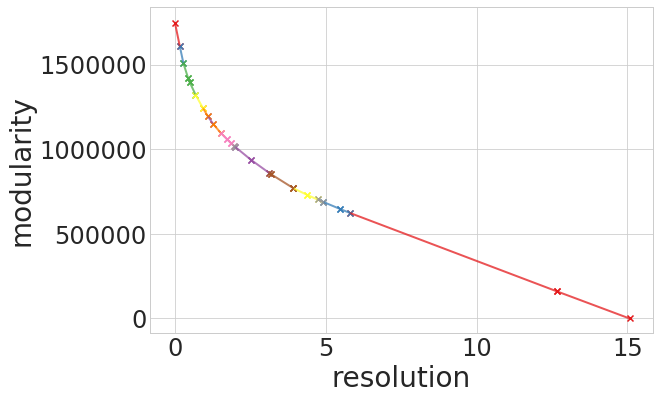

In [9]:
el_path = '/home/jessime/Research/mrna_lncrna/M14_extend_el.tab.gz'
fig_path = '/home/jessime/Research/pics/M14_extend_champ100.pdf'
df_path = '/home/jessime/Research/mrna_lncrna/M14_extend_champ100.csv'
top_path = '/home/jessime/Research/mrna_lncrna/M14_extend_champ100_top.csv'
ratios_path = '/home/jessime/Research/mrna_lncrna/M14_extend_champ100_ratios.csv'
champ_runner = network.ChampRunner(el_path, fig_path, df_path, top_path, ratios_path)
champ_runner.run()

Run 0 at gamma = 0.100.  Return time: 242.2459
Run 10 at gamma = 0.600.  Return time: 132.9393
Run 20 at gamma = 1.100.  Return time: 151.7467
Run 30 at gamma = 1.600.  Return time: 139.0531
Run 50 at gamma = 2.600.  Return time: 189.0201
Run 40 at gamma = 2.100.  Return time: 192.6085
Run 70 at gamma = 3.600.  Return time: 190.9696
Run 60 at gamma = 3.100.  Return time: 152.1353
Run 80 at gamma = 4.100.  Return time: 144.7831
Run 90 at gamma = 4.600.  Return time: 42.4848


/home/jessime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


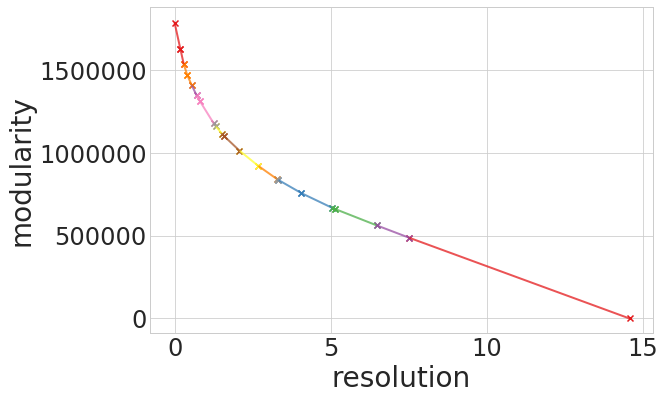

In [10]:
el_path = '/home/jessime/Research/mrna_lncrna/M14_extend_log_el.tab.gz'
fig_path = '/home/jessime/Research/pics/M14_extend_log_champ100.pdf'
df_path = '/home/jessime/Research/mrna_lncrna/M14_extend_log_champ100.csv'
top_path = '/home/jessime/Research/mrna_lncrna/M14_extend_log_champ100_top.csv'
ratios_path = '/home/jessime/Research/mrna_lncrna/M14_extend_log_champ100_ratios.csv'
champ_runner = network.ChampRunner(el_path, fig_path, df_path, top_path, ratios_path)
champ_runner.run()